In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件，不指定数据类型，让pandas自动识别
data = pd.read_csv('preprocess2.csv')

# 处理缺失值（填充或删除含有缺失值的行）
data = data.dropna()
data = data.tail(10000)

# 将分类变量转化为虚拟变量（独热编码），排除目标变量
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 定义需要预测的目标变量
target = '紫外线（指数）'
results = {}

# 设置交叉验证的折数和参数范围
kf = KFold(n_splits=5, shuffle=True, random_state=1)
neighbors = list(range(1, 31))  # 邻居数从1到30

# 将当前目标变量y，其余作为特征X
X = data.drop(columns=[target])
y = data[target]
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        features = x  # 中间层的输出作为特征
        x = self.fc2(x)
        return x, features


Epoch [1/40], Loss: 10.1702
Epoch [2/40], Loss: 4.0397
Epoch [3/40], Loss: 3.7402
Epoch [4/40], Loss: 3.5416
Epoch [5/40], Loss: 3.3955
Epoch [6/40], Loss: 3.2606
Epoch [7/40], Loss: 3.1642
Epoch [8/40], Loss: 3.0751
Epoch [9/40], Loss: 3.0188
Epoch [10/40], Loss: 2.9214
Epoch [11/40], Loss: 2.8562
Epoch [12/40], Loss: 2.7957
Epoch [13/40], Loss: 2.7895
Epoch [14/40], Loss: 2.7710
Epoch [15/40], Loss: 2.7927
Epoch [16/40], Loss: 2.7666
Epoch [17/40], Loss: 2.7028
Epoch [18/40], Loss: 2.6587
Epoch [19/40], Loss: 2.6720
Epoch [20/40], Loss: 2.6736
Epoch [21/40], Loss: 2.6709
Epoch [22/40], Loss: 2.6275
Epoch [23/40], Loss: 2.6255
Epoch [24/40], Loss: 2.5875
Epoch [25/40], Loss: 2.5721
Epoch [26/40], Loss: 2.6051
Epoch [27/40], Loss: 2.5836
Epoch [28/40], Loss: 2.5698
Epoch [29/40], Loss: 2.5514
Epoch [30/40], Loss: 2.6255
Epoch [31/40], Loss: 2.5356
Epoch [32/40], Loss: 2.5396
Epoch [33/40], Loss: 2.5376
Epoch [34/40], Loss: 2.5213
Epoch [35/40], Loss: 2.5279
Epoch [36/40], Loss: 2.5850


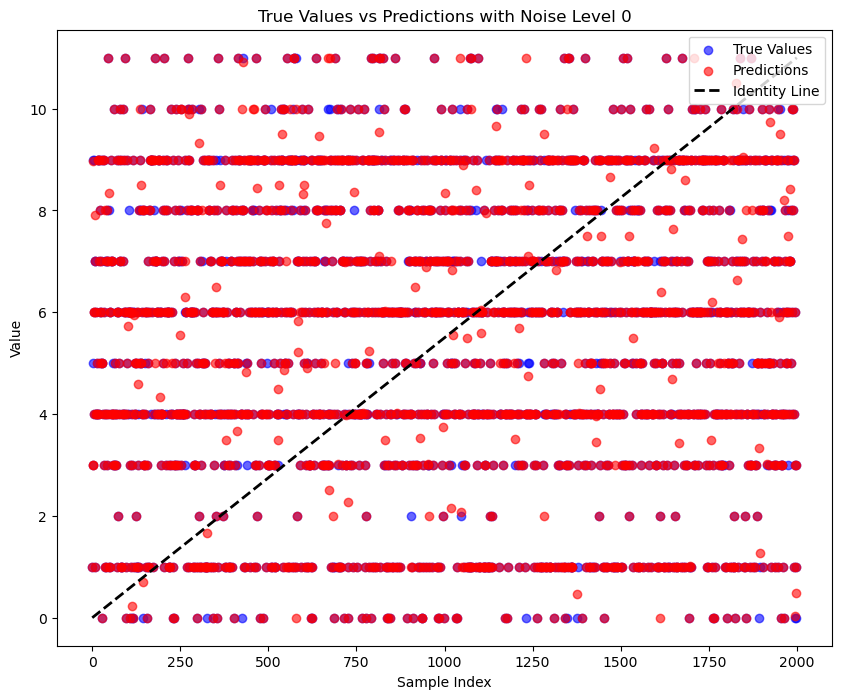

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

目标的评价指标:
测试集MSE: 0.501
测试集RMSE: 0.708
测试集MAE: 0.233
训练集R²分数: 0.957
测试集R²分数: 0.937


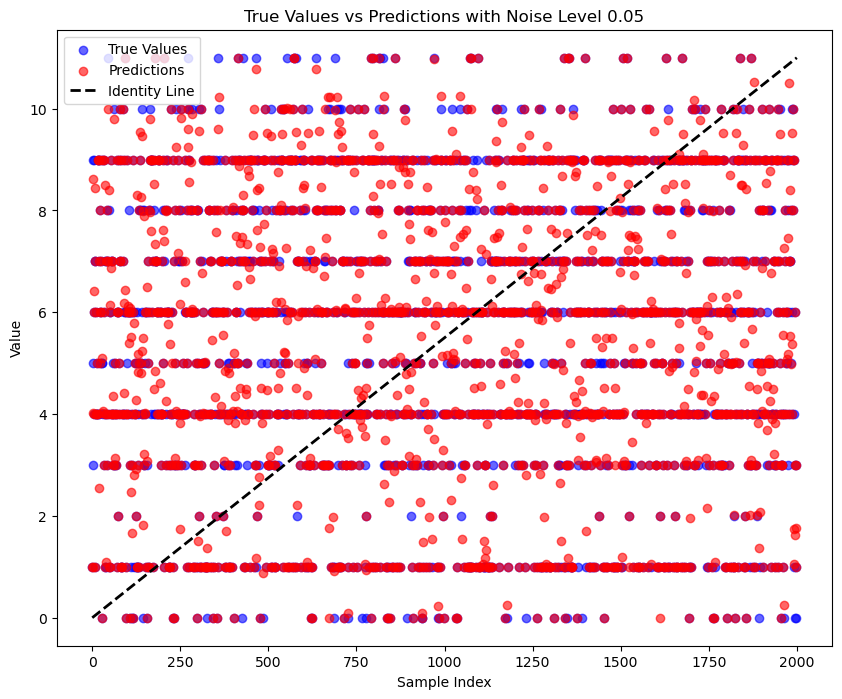

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

目标的评价指标:
测试集MSE: 0.697
测试集RMSE: 0.835
测试集MAE: 0.265
训练集R²分数: 0.933
测试集R²分数: 0.912


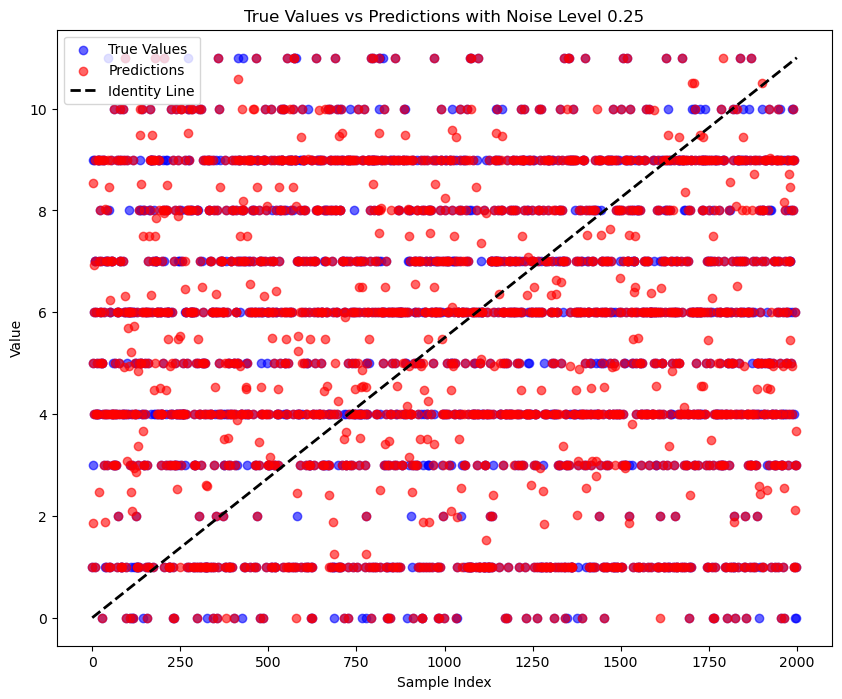

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

目标的评价指标:
测试集MSE: 0.946
测试集RMSE: 0.973
测试集MAE: 0.480
训练集R²分数: 0.905
测试集R²分数: 0.881


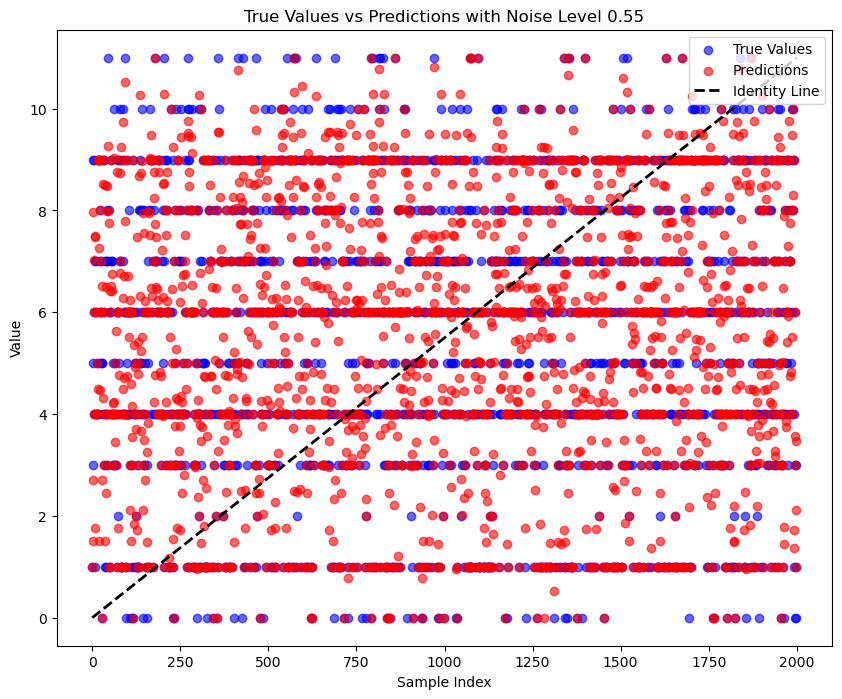

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}

目标的评价指标:
测试集MSE: 1.395
测试集RMSE: 1.181
测试集MAE: 0.741
训练集R²分数: 0.837
测试集R²分数: 0.825


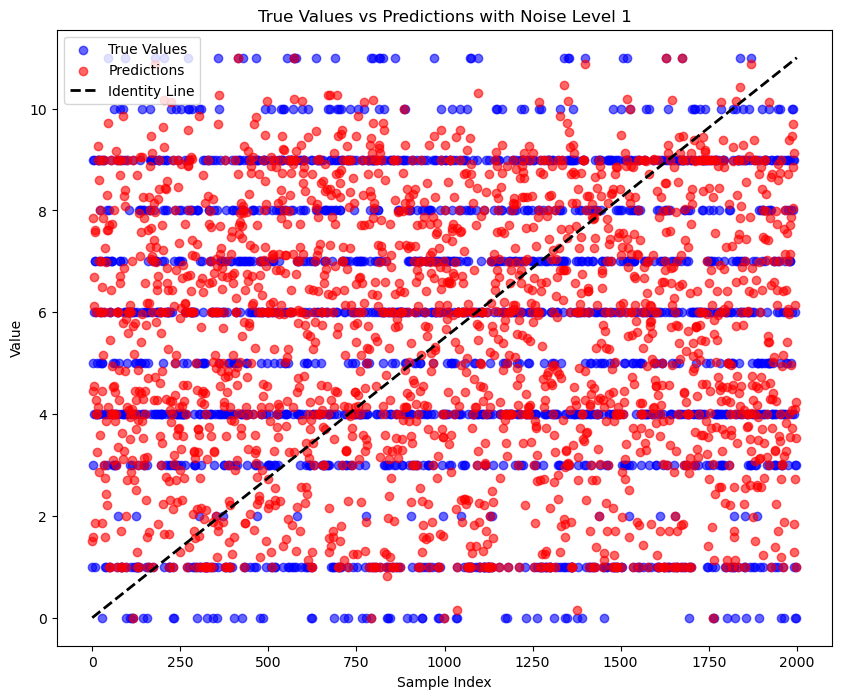

In [6]:
# PCA降维
pca = PCA(n_components=0.95)  # 保留95%的方差
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

input_size = X_train_pca.shape[1]
hidden_size = 50
output_size = 1

model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 动态学习率调整
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    scheduler.step(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

model.eval()
with torch.no_grad():
    _, train_features = model(X_train_tensor)
    _, test_features = model(X_test_tensor)

features_train = train_features.numpy()
features_test = test_features.numpy()

# 添加噪声的不同水平
noise_list = [0,0.05,0.25,0.55,1]

R2_train_list,MSE_test_list, RMSE_test_list, MAE_test_list, R2_test_list = [], [], [], [],[]


for noise_level in noise_list:  # 噪声水平，根据数据范围和需求调整
    # 向训练数据添加噪声
    X_train_noisy = features_train + noise_level * np.random.normal(size=features_train.shape)

    # 确保噪声数据在原数据的范围内，例如通过clip方法
    X_train_noisy = np.clip(X_train_noisy, features_train.min(), features_train.max())

    # 使用GridSearchCV选择最佳n_neighbors和权重参数
    param_grid = {
        'n_neighbors': range(1, 21),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }


    grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_noisy, y_train)

    best_knn_regressor = grid_search.best_estimator_

    # 进行预测
    y_train_pred = best_knn_regressor.predict(X_train_noisy)
    y_pred = best_knn_regressor.predict(features_test)

    # 计算训练集和测试集的MSE、RMSE、MAE和R²分数
    train_r2 = best_knn_regressor.score(features_train, y_train)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = best_knn_regressor.score(features_test, y_test)

    results = {
        '测试集MSE': test_mse,
        '测试集RMSE': test_rmse,
        '测试集MAE': test_mae,
        '训练集R²分数': train_r2,
        '测试集R²分数': test_r2
    }


    R2_train_list.append((noise_level, train_r2))
    MSE_test_list.append((noise_level, test_mse))
    RMSE_test_list.append((noise_level, test_rmse))
    MAE_test_list.append((noise_level, test_mae))
    R2_test_list.append((noise_level, test_r2))

    # 打印结果
    best_params = best_knn_regressor.get_params()
    print(best_params)
    print(f"\n目标的评价指标:")
    for metric, value in results.items():
        print(f"{metric}: {value:.3f}")
    # 可视化回归残差
    plt.figure(figsize=(10, 8))
    plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
    plt.scatter(range(len(y_test)), y_pred, color='red', alpha=0.6, label='Predictions')
    plt.plot([0, len(y_test)], [y_test.min(), y_test.max()], 'k--', lw=2, label='Identity Line')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'True Values vs Predictions with Noise Level {noise_level}')
    plt.legend()
    plt.show()


In [7]:
print(f'MSE result:{MSE_test_list}')
print(f'RMSE result:{RMSE_test_list}')
print(f'MAE result:{MAE_test_list}')
print(f'R2 Score result or train set:{R2_train_list}')
print(f'R2 Score result or test set:{R2_test_list}')

MSE result:[(0, 0.5771662708258957), (0.05, 0.501230217081925), (0.25, 0.6969096475316078), (0.55, 0.9462054537758701), (1, 1.3949570365861772)]
RMSE result:[(0, 0.7597145982708873), (0.05, 0.7079761416050155), (0.25, 0.8348111448295403), (0.55, 0.9727309256808226), (1, 1.1810829930983586)]
MAE result:[(0, 0.16517836547315506), (0.05, 0.2332672785031332), (0.25, 0.26487672123678535), (0.55, 0.47962311055738627), (1, 0.741464326793825)]
R2 Score result or train set:[(0, 0.9844479105996712), (0.05, 0.9573674092941865), (0.25, 0.9331313396140003), (0.55, 0.9049389110623514), (1, 0.837334877475889)]
R2 Score result or test set:[(0, 0.9274394509784875), (0.05, 0.9369860271190251), (0.25, 0.9123854785018504), (0.55, 0.8810443529299077), (1, 0.8246279217056878)]


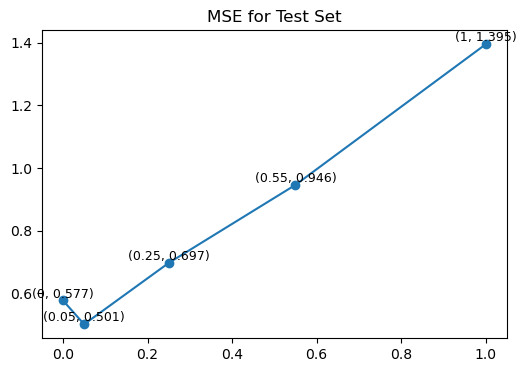

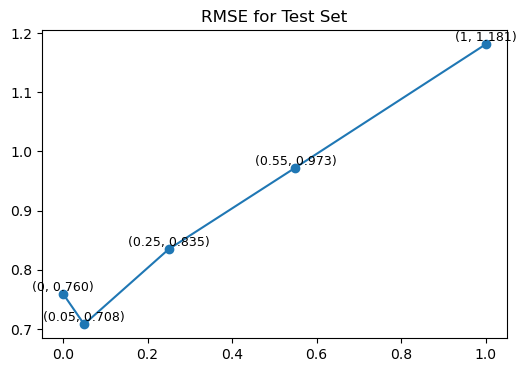

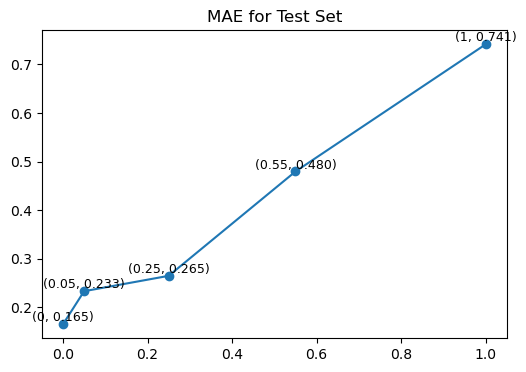

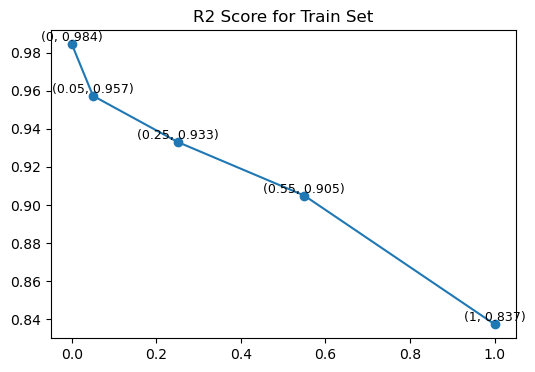

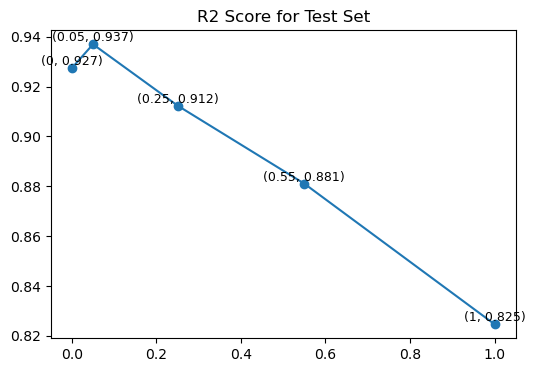

In [8]:
array_grid_list = [MSE_test_list, RMSE_test_list, MAE_test_list,R2_train_list, R2_test_list]
titles_grid_2 = ['MSE for Test Set','RMSE for Test Set','MAE for Test Set','R2 Score for Train Set','R2 Score for Test Set']

for i,(list,title) in enumerate(zip(array_grid_list,titles_grid_2)):
    plt.figure(figsize=(6, 4))
    x = [tup[0] for tup in list]
    y = [tup[1] for tup in list]
    plt.plot(x, y, marker='o')
    for (xi, yi) in zip(x, y):
        plt.text(xi, yi, f'({xi}, {yi:.3f})', fontsize=9, ha='center', va='bottom')
    plt.title(title) 
plt.show()

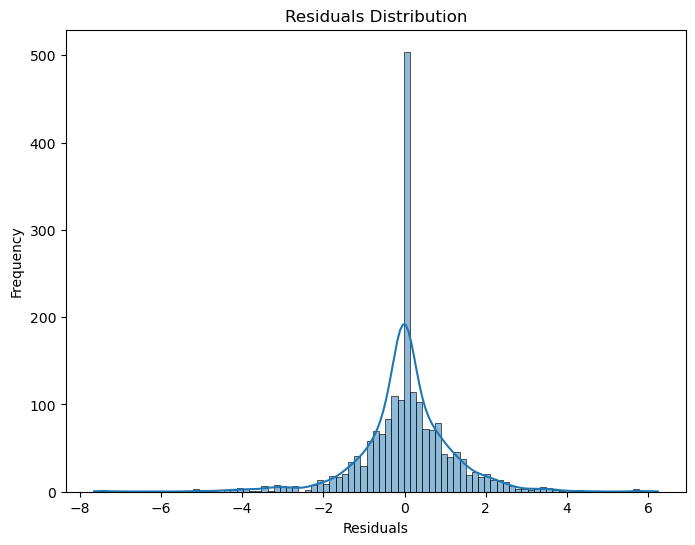

In [9]:
import seaborn as sns

plt.figure(figsize=(8, 6))
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()